In [1]:
!pip install kaggle

!mkdir .kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import zipfile
import os
from pathlib import Path
api_token = {"username":"ratchaphonp",
             "key":"9ce222230cae5d8fadeaa490ee7d9e29"}
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_token,handl)

In [3]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ratchaphonp/new-image

100% 26.4G/26.4G [04:38<00:00, 130MB/s]
100% 26.4G/26.4G [04:38<00:00, 102MB/s]


In [ ]:
!unzip new-image.zip

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [6]:
os.mkdir("newtrain")
train = os.path.join("newtrain", "train")
valid = os.path.join("newtrain", "valid")
os.mkdir(train)
os.mkdir(valid)
train_benign = os.path.join("newtrain/train", "benign")
train_malignant = os.path.join("newtrain/train", "malignant")
valid_benign = os.path.join("newtrain/valid", "benign")
valid_malignant = os.path.join("newtrain/valid", "malignant")
os.mkdir(train_benign)
os.mkdir(train_malignant)
os.mkdir(valid_benign)
os.mkdir(valid_malignant)

In [7]:
num_test = len(os.listdir('/content/test/test/malignant'))
num_test

265

In [8]:
#os.mkdir("test")
test_benign = os.path.join('test', "benign")
test_ca = os.path.join('test', 'malignant')
os.mkdir(test_benign)
os.mkdir(test_ca)

In [9]:
name_test_ca = list(os.listdir('/content/test/test/malignant'))
name_test_benign = list(os.listdir('/content/test/test/benign'))

In [10]:
random.shuffle(name_test_benign)
test_benign = name_test_benign[:num_test] 

In [11]:
len(name_test_benign)

1600

In [12]:
for name_ca in name_test_ca:
    path = '/content/test/test/malignant/'
    shutil.copy(path+name_ca, '/content/test/malignant/')
for name_nonca in test_benign:
    path = '/content/test/test/benign/'
    shutil.copy(path+name_nonca, '/content/test/benign/')

In [13]:
test_ca = len(os.listdir('/content/test/malignant/'))
test_nonca = len(os.listdir('/content/test/benign/'))

In [14]:
name_ca = list(os.listdir('/content/train/train/malignant'))
len(name_ca)

5040

In [15]:
valid_size = 0.1 
valid_number = int(len(name_ca) * valid_size)
random.shuffle(name_ca)
valid_set_ca = name_ca[:valid_number]
train_set_ca = name_ca[valid_number:]
name_nonca = list(os.listdir('/content/train/train/benign'))
random.shuffle(name_nonca)
valid_set_nonca = name_nonca[:valid_number]
train_set_nonca = name_nonca[valid_number:5040]

In [16]:
print(f"valid for ca = {len(valid_set_ca)}")
print(f"valid for nonca = {len(valid_set_nonca)} ")
print(f"train for ca = {len(train_set_ca)}")
print(f"train for nonca = {len(train_set_nonca)} ")
print(f"test for ca = {test_ca}")
print(f"test for nonca = {test_nonca}")

valid for ca = 504
valid for nonca = 504 
train for ca = 4536
train for nonca = 4536 
test for ca = 265
test for nonca = 265


In [17]:
for ca in valid_set_ca:
    path = '/content/train/train/malignant/'
    shutil.copy(path+ca, '/content/newtrain/valid/malignant/')
for ca in train_set_ca:
    path = '/content/train/train/malignant/'
    shutil.copy(path+ca, '/content/newtrain/train/malignant/')
for nonca in valid_set_nonca:
    path = '/content/train/train/benign/'
    shutil.copy(path+nonca, '/content/newtrain/valid/benign/')
for nonca in train_set_nonca:
    path = '/content/train/train/benign/'
    shutil.copy(path+nonca, '/content/newtrain/train/benign/')

In [18]:
train_dir = '/content/newtrain/train'
valid_dir = '/content/newtrain/valid'

In [19]:
img_height = 256
img_width = 256
batch_size_16 = 16
train_ds = tf.keras.utils.image_dataset_from_directory(
          train_dir,
          image_size=(img_height, img_width),
          batch_size=batch_size_16)

valid_ds = tf.keras.utils.image_dataset_from_directory(
          valid_dir,
          image_size=(img_height, img_width),
          batch_size=batch_size_16)

Found 9072 files belonging to 2 classes.
Found 1008 files belonging to 2 classes.


In [20]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


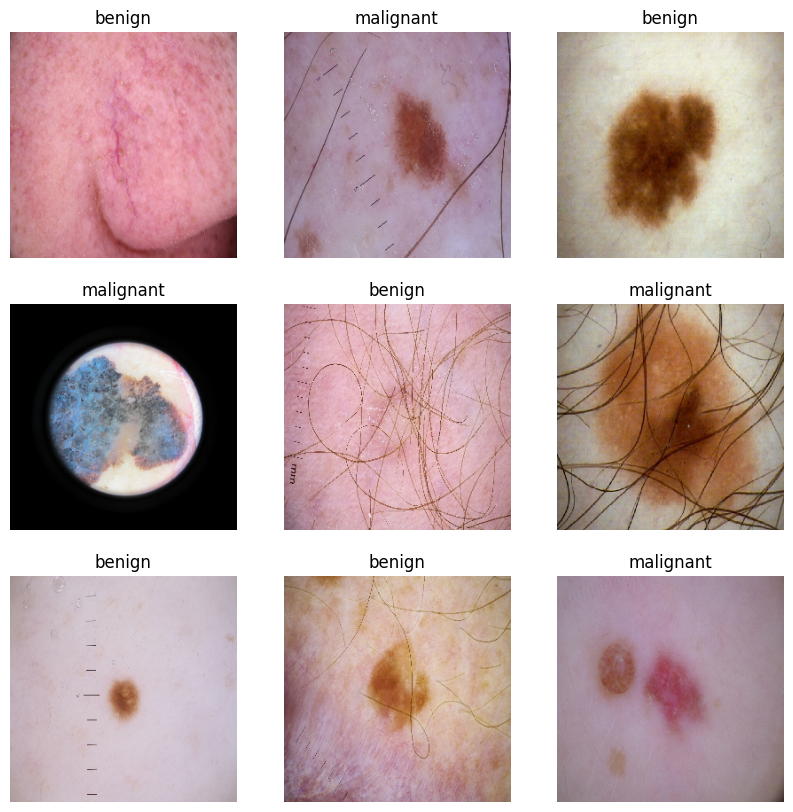

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

In [23]:
import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)    
  ]
)

resize_and_rescale = tf.keras.Sequential([
    #layers.CenterCrop(CCrop,CCrop),
    #layers.Resizing(512, 512),
    layers.Rescaling(1./255.)
])

In [24]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from keras.applications import DenseNet201
pre_trained_model = DenseNet201(include_top = False,weights = 'imagenet')
    
for layer in pre_trained_model.layers:
  layer.trainable = False
pre_trained_model.summary()

In [27]:
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=7, min_lr=0.000000001),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_weight.h5',save_best_only=True, verbose=2),
    tf.keras.callbacks.EarlyStopping(patience=15),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    
]

In [28]:
def custom_model(pre_trained_model, lr, input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = resize_and_rescale(x)
    x = pre_trained_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs = inputs,outputs= x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model

In [29]:
model = custom_model(pre_trained_model, 0.001, (256,256,3))

In [30]:
history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs = 50,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0.8334
Epoch 1: val_loss improved from inf to 0.30650, saving model to model_weight.h5
567/567 [==============================] - 440s 719ms/step - loss: 1.3741 - accuracy: 0.8334 - val_loss: 0.3065 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8674
Epoch 2: val_loss improved from 0.30650 to 0.25874, saving model to model_weight.h5
567/567 [==============================] - 402s 703ms/step - loss: 0.3279 - accuracy: 0.8674 - val_loss: 0.2587 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8769
Epoch 3: val_loss did not improve from 0.25874
567/567 [==============================] - 403s 703ms/step - loss: 0.3048 - accuracy: 0.8769 - val_loss: 0.2720 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/50
567/567 [==============================] - ETA

In [31]:
%rm -rf /content/test/test

In [32]:
test_dir = '/content/test'

In [33]:
model.save('DN.h5')

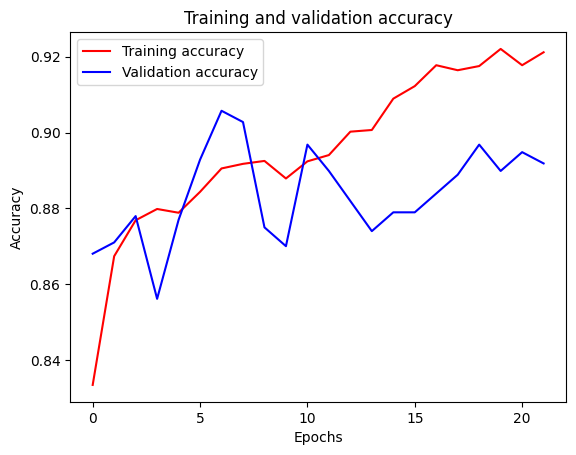

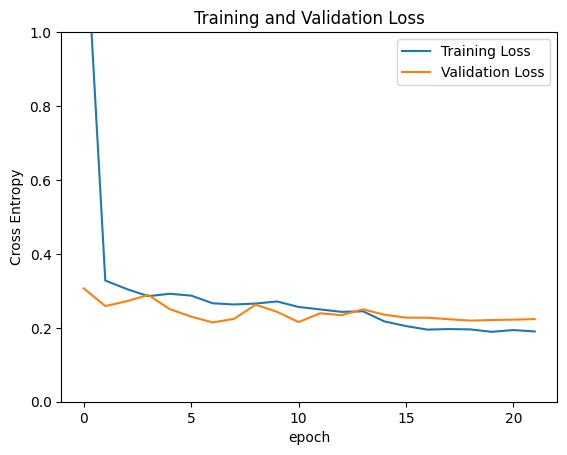

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



plt.show()

In [35]:
test = tf.keras.utils.image_dataset_from_directory(
          test_dir,
          image_size=(img_height, img_width),
          batch_size=batch_size_16)

Found 530 files belonging to 2 classes.


In [36]:
model.evaluate(test)

34/34 [==============================] - 25s 540ms/step - loss: 0.2459 - accuracy: 0.8962


[0.2459482103586197, 0.8962264060974121]

In [37]:
pred = []
label = []

In [38]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as pl
from tensorflow.keras.utils import img_to_array

In [39]:
test_ca = os.listdir('/content/test/malignant')
test_nonca = os.listdir('/content/test/benign')

In [ ]:
for name in test_ca:
    img_path = '/content/test/malignant/' + name
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img)
    #img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    predic = model.predict(img_batch)
    if predic < 0.5 :
        pred.append(0)
        label.append(1)
        
    else:
        pred.append(1)
        label.append(1)
        

In [ ]:
for name in test_nonca:
    img_path = '/content/test/benign/' + name
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img)
    #img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    predic = model.predict(img_batch)
    if predic < 0.5 :
        pred.append(0)
        label.append(0)
        
    else:
        pred.append(1)
        label.append(0)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       265
           1       0.98      0.80      0.88       265

    accuracy                           0.89       530
   macro avg       0.90      0.89      0.89       530
weighted avg       0.90      0.89      0.89       530



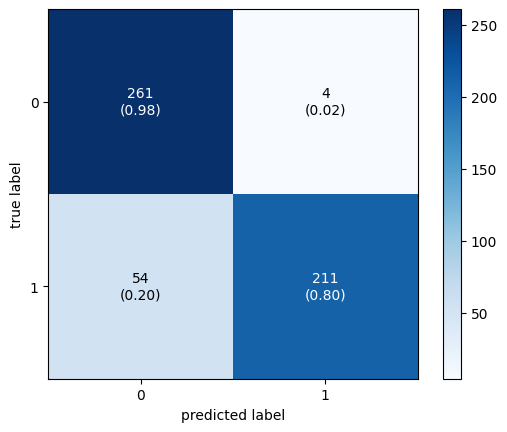

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(label, pred))
cm1 = confusion_matrix(label, pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()